In [1]:
# Set imports
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler

### Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA:
University of California, School of Information and Computer Science.

Source: Data Source: http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

### Evaluating A Linear Regression Model

1 - Mean Absolute Error <br>
&emsp;&emsp;* Lets take all of the errors/residuals, sum the distance, take the average <br>
&emsp;&emsp;* This says how far off we are <br>
&emsp;&emsp;* $\displaystyle \Bigg[\frac{\sum \limits _{i=1} ^{n} |y_{i} - \hat{y_{i}}|}{n}\Bigg]$ <br><br>

2 - Mean Squared Error <br>
&emsp;&emsp;* Same concept but to punish distance from linear model more harshly <br>
&emsp;&emsp;* To do this we square the summation <br>
&emsp;&emsp;* This is good for removing outliers as they will face a more intense value weighting. <br>
&emsp;&emsp;* $\displaystyle \Bigg[\frac{\sum \limits _{i=1} ^{n} |y_{i} - \hat{y_{i}}|^{2}}{n}\Bigg]$ <br><br>

3 - Root Mean Squared Error <br>
&emsp;&emsp;* Same concept but to punish distance from linear model more harshly <br>
&emsp;&emsp;* To do this we square the summation <br>
&emsp;&emsp;* This is good for more direct comparison to Y. The root mean squared provides an easier y comparion <br>
&emsp;&emsp;* $\displaystyle \sqrt{\Bigg[\frac{\sum \limits _{i=1} ^{n} |y_{i} - \hat{y_{i}}|^{2}}{n}\Bigg]}$<br><br>

4 - Coefficient of Determination <br>
&emsp;&emsp;* RSS - Sum of Squared Residuals -> The Numerator in the Above Functions<br>
&emsp;&emsp;* TSS - Total Sum of Squares<br><br>
&emsp;&emsp;* TSS = $\displaystyle \sum \limits _{i=1} ^{n} |y_{i} - \bar{y_{i}}|^{2}$<br><br>
&emsp;&emsp;* Notice Instead of predicted value '^' we use average/mean value '-'<br>
&emsp;&emsp;* A value close to 0 with $R^{2}$ is a good indicator usually<br><br>
&emsp;&emsp;* $R^{2} = 1 - \Bigg[\frac{RSS}{TSS}\Bigg]$ <br><br>


### Data Organization and Cleanup

In [2]:
# Let's name the columns
dataset_cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snow', 'functional']

# To remove select columns add "drop", dropping... the date, holiday, and seasons columns, applying to columns axis
df = pd.read_csv("DataSets/seoulBikeSharingDemand/SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)
df.head()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [3]:
# Name columns and remove hour, and make functional an on/off int value
df.columns = dataset_cols
df['functional'] = (df['functional'] == 'YES').astype(int)
df = df[df['hour'] == 12]
df = df.drop(['hour'], axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


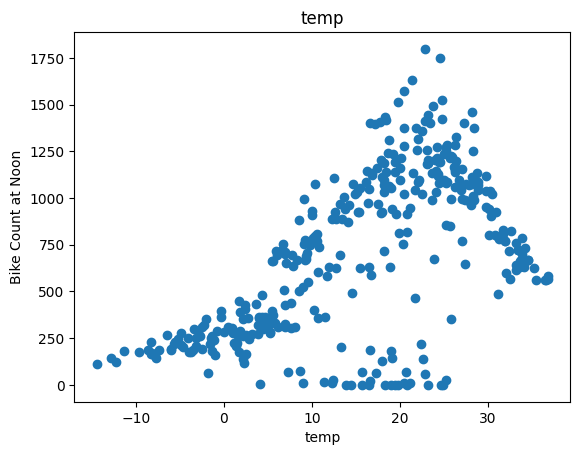

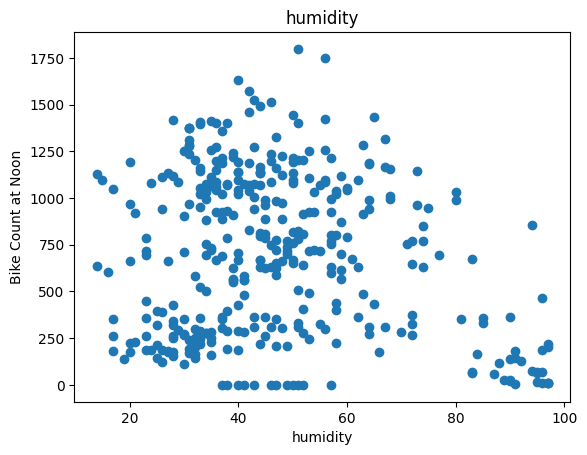

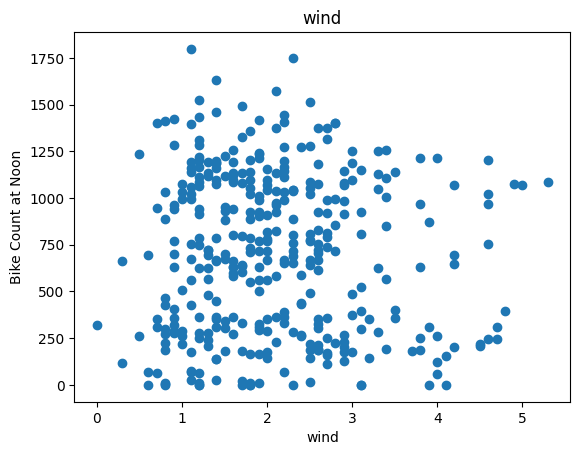

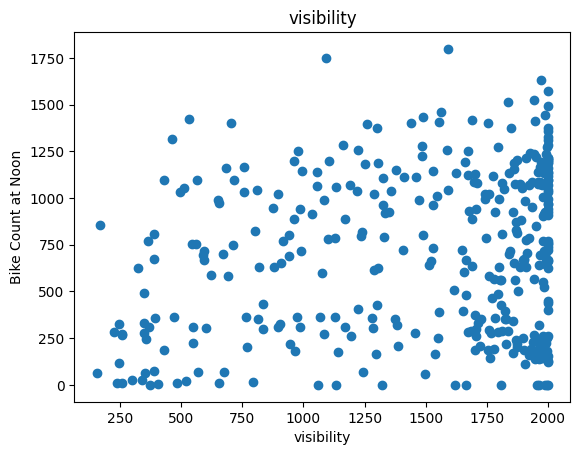

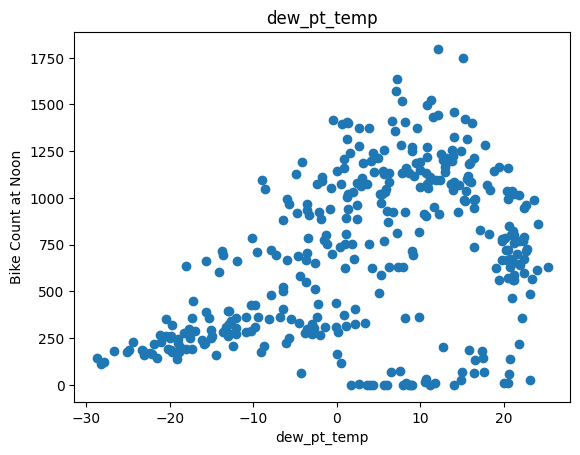

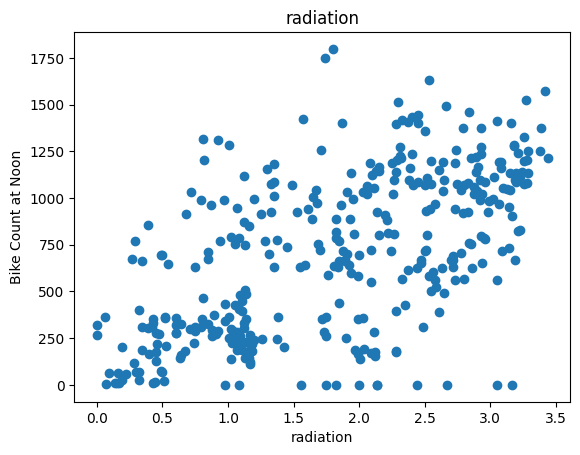

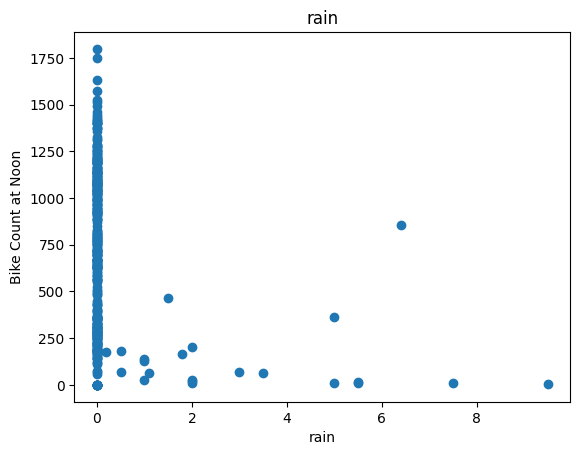

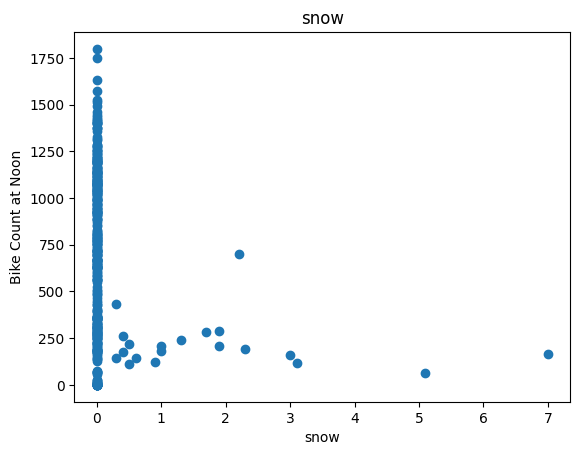

In [4]:
# For every label or category how does this effect bike count via scatter plot
# The range listed is for making sure to not compare bike_count to bike_count so we skip 0
# We stop short as functional is just an on/off value
for label in df.columns[1:-1]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()

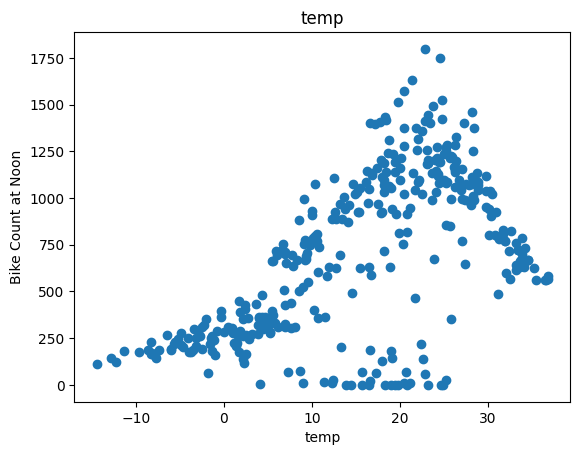

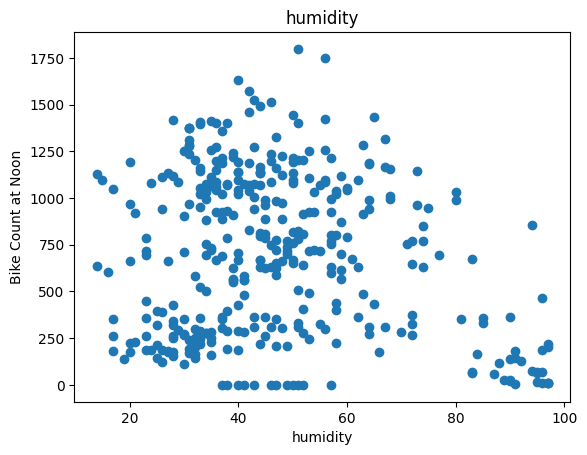

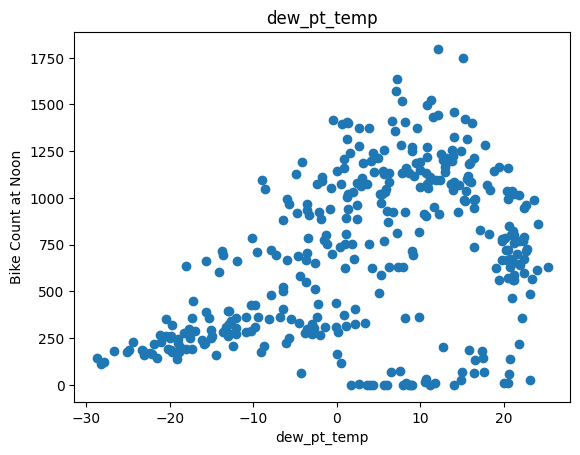

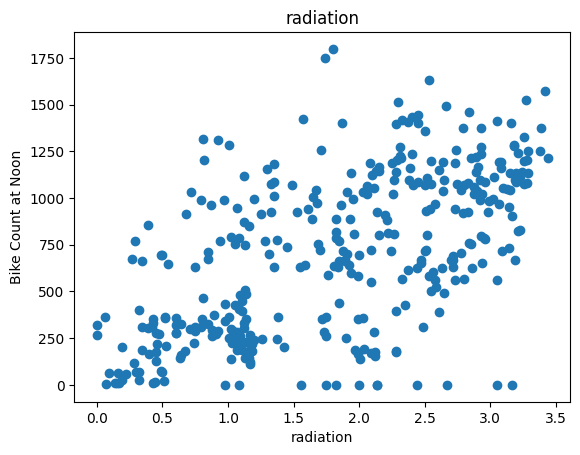

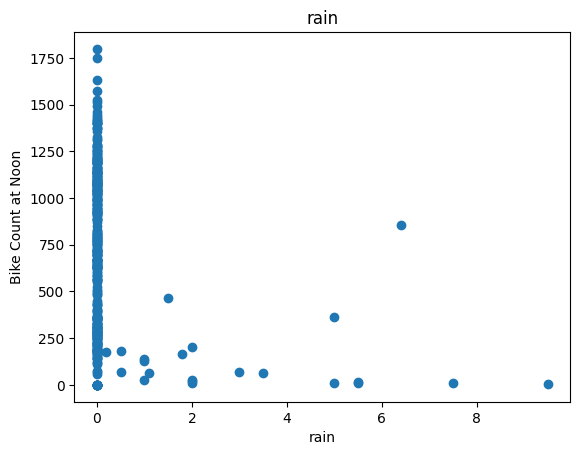

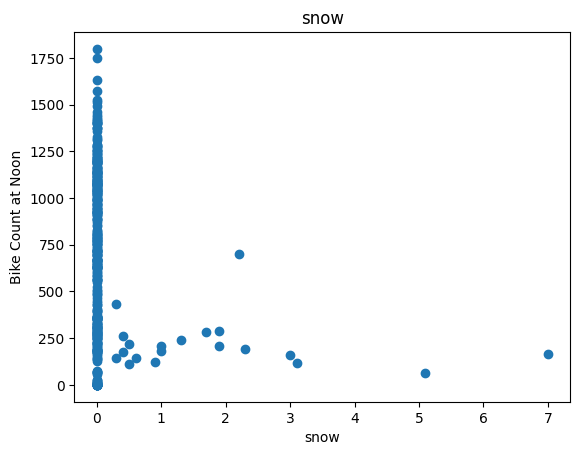

In [5]:
# After deciding visually Wind, and Rain had too weak a correlation to have validity
# We drop them and reprint the scatter plots.
df = df.drop(["wind", "visibility"], axis=1)
for label in df.columns[1:-1]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()

### Train, Validate, and Test

In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
# Setup up a function to deal with defaults, single value, or no value operation
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!= y_label]].values
    else:
        if len(x_labels) ==1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,y))

    return data, X, y

In [8]:
# Start off with single value of temp. It may yield results based on visual perception
dataArr_temp, X_train_temp, y_train_temp = get_xy(df, 'bike_count', x_labels=['temp'])
dataArr_temp, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
dataArr_temp, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [9]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [10]:
print("Temperature Regression Coefficient: " + str(temp_reg.coef_), "Temperature Regression X-Intercept: " + str(temp_reg.intercept_))

Temperature Regression Coefficient: [[20.84124918]] Temperature Regression X-Intercept: [377.18970415]


In [11]:
print("R Squared (^2) Value: " +str(temp_reg.score(X_test_temp, y_test_temp)))

R Squared (^2) Value: 0.24339297491377032


### Not an Unrelated Result, but Also Not a Great Result!

Let's plot this Its a lot of little items. <br>
1 - Create Scatter Plot Labeling Data Points. <br>
2 - Create a Linear Regression Space from -20 -> 40 using 100 total values. <br>
3 - Plot after using the linear regression to predict the u values; This must also be reshaped. <br>
4 - Name the line, design and label the remaining information. <br>

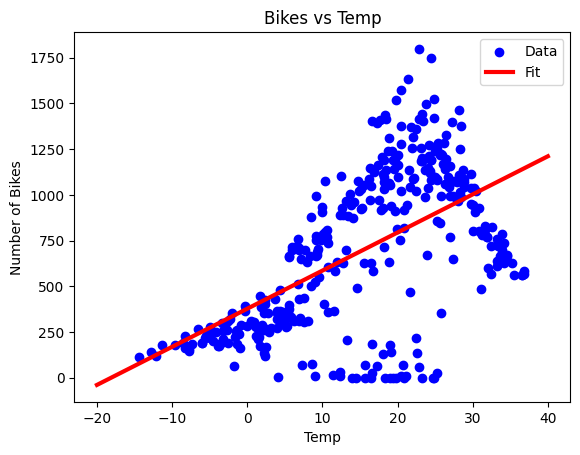

In [12]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

### Multiple Linear Regression

Here we will use all of the columns excluding out Y Label (Bike_Count)

In [13]:
dataArr, X_train_all, y_train_all = get_xy(df, 'bike_count', x_labels=df.columns[1:])
dataArr, X_val_all, y_val_all = get_xy(val, 'bike_count', x_labels=df.columns[1:])
dataArr, X_test_all, y_test_all = get_xy(test, 'bike_count', x_labels=df.columns[1:])

In [14]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [15]:
print("R Squared (^2) Value: " + str(all_reg.score(X_test_all, y_test_all)))

R Squared (^2) Value: 0.40714597943430475


Sizable percentage improvement. Time for a Neural Net with only Temp

## Regression with Neural Net

In [16]:
# Create layer to normalize the data; Only using temperature on this instance
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1, ), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

C:\Users\BabyLogan\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Create the model using the normalizer, and only 1 dense layer
# One dense layer makes the input linear
# Making it a one node layer with no activation function makes it a linear output
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [18]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [19]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose = 0,
    epochs = 1000,
    validation_data = (X_val_temp, y_val_temp))

In [20]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.show()

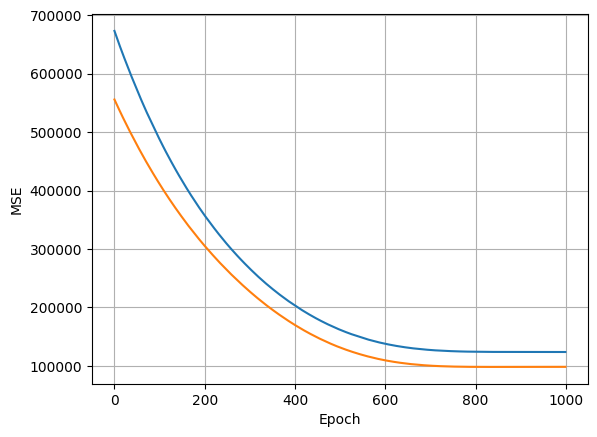

In [21]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Text(0.5, 0, 'Temp')

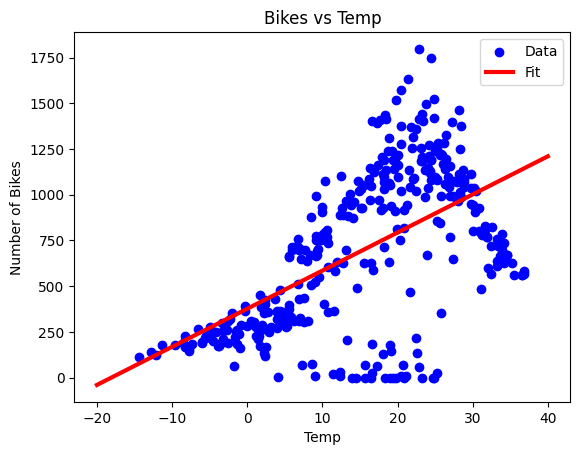

In [22]:
# Rerun the previous Scatter Plot Creatin from ealier
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")

Very slight difference in the linear line drawn by neural net vs linear regression.

In [23]:
# Renormalization
# Create layer to normalize the data; Only using temperature on this instance
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1, ), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

# Create the model using the normalizer, and a full Neural Net
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')


In [24]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0,
    epochs=100,
)

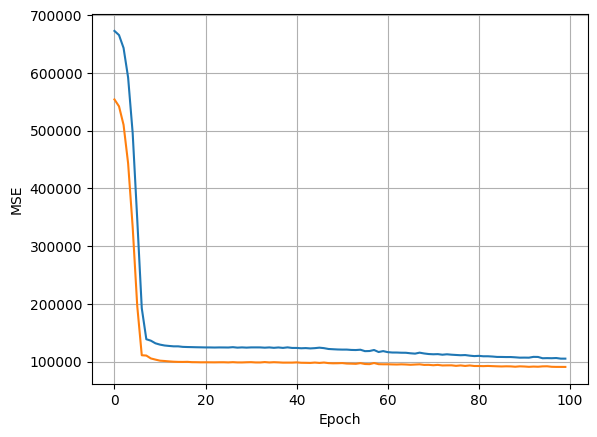

In [25]:
plot_loss(history)